# Week 2 workshop discussions
> We talk about entropy, decision trees and random forest. 

- toc: true 
- badges: true
- comments: true
- categories: [machine-learning, workshop, decision-tree, random-forest, information-theory]


----
# Workshop plan

 1. We will first finish up NaiveBayes classifier from last week. We will do demo on this, illustrating Bayesian inference and the "naive" assumption. This will hopefully illustrate some aspect of information entropy as well. 
 2. Then we will talk about DecisionTreeClassifier. We will discuss this in detail. It is important to understand the "splitting criterion". 
   - We will understand the basic concept of **Entropy** first. (Q1 written) 
     - Demo: number guessing game, probable event encoding. 
     - Entropy as "average surprise". We want "additive surprise on independent events". 
     - Entropy as a function of distribution. $H(p)$
     - Entropy as a funciton of random variable. $H(X)$
     - Entropy of a set. $H(A)$
     - Conditional entropy. $H(Y | X)$
   - Use entropy to define "information gain". (Q2 written). 
 3. Next, we talk about "ensembling". 
   - Example: "crowd wisdom". 
   - The need for classifiers to be "as independent / diverse as possible". 
   - Bagging: drawing with replacement. 
   - Random Forest classifier. 
 4. Some coding exercise: Q3, Q4. We will see some "preprocessing" of data. 
 5. We will talk about what ML people call "hyperparameters". Why "hyper"? 
   - Hyperparameters in random forest Q5. 
 6. If time permits, we will talk about: 
   - Any question you have. 
   - Overfitting. 
   - Some possibly useful external materials for better understanding. 
 7. Summary. What do you absolutely need to master from these very diverse materials? 


In [90]:
#collapse-hide
import numpy as np
import matplotlib.pyplot as plt
import scipy

from ipywidgets import interact

---
# Bayesian inference demo
---
Below is a classic demonstration of Bayesian inference. The likelihood we set up will also illustrate the "naive" assumptions used in the NaiveBayes classifier. 

## Set up
A point $(x^*, y^*)$ is randomly chosen on the unit square $[0, 1] \times [0, 1]$. Our task is to find out where that point is based on a sequence of relative direction of randomly generated points on the square. E.g. If $(x^*, y^*) = (0.5, 0.5)$ and the first randomly generated point is $(x_1, y_1) = (0.9, 0.3)$ then we obtain one data point of $SE$ since $(x, y)$ is south east of $(x^*, y^*)$. 

## Likelihood function
The likelihood of observing $N$ north calls and $E$ east calls in a sequence of $n$ points is given by 

$$
\begin{align*}
L(x, y) 
&= p(N, E | x^*, y) \\
&= p(N | y) p(E | x) \\
&= \binom{n}{N}(1-y)^N y^{n - N} \binom{n}{E} (1 - x)^E x^{n - E}.
\end{align*}
$$
Notice that 
  * We are assuming that the points are generated **uniformly at random**. The set up did not tell us that, we are making a modelling assumption here. 
  * In constructing the likelihood function above, we assumed that the North-South and East-West direction are independent. This is not true in general, this is the "naive" assumption, though in this case this follows from the much stronger first assumption above. 
  * The likelihood function is usually thought of as a function of the information we wish to know, in this case the position of the point $P = (x^*, y^*)$, and the likelihood $L(x, y)$ is asking "what is the probability of observing the sequence $\{NE, SE, \dots\}$ data if $P = (x, y)$". Crucially, this is *NOT* the probabiliy of $(x, y)$ in any sense of the word. To get the probability interpretation, we need Bayes formula. 


## Bayes formula
$$
p(x, y | N, E) = \frac{L(x, y) p(x, y)}{p(N, E)}
$$
where $p(x, y)$ is a prior and $p(N, E)$ is the evidence (while it is just a normalising constant, it is the term that tell us how likely our modelling assumption is. If the true point generator far from uniform, then evidence is going to be really low). 


## Demo
Run the follow cell in a Jupyter notebook and give different values of $N$ and $E$ (and control the total $n$ by giving corresponding $S$ and $W$) to see how the posterior changes and how the Maximum Likelihood estimate need not agree with what the posterior says. 

In [94]:
#collapse-hide
def log_likelihood(north, south, east, west, x, y):
    x_term = east * np.log(1 - x) + west * np.log(x) 
    y_term = north * np.log(1 - y) + south * np.log(y)
    return x_term + y_term

MAX_N = 8
@interact(
    north=(0, MAX_N), 
    south=(0, MAX_N), 
    east=(0, MAX_N), 
    west=(0, MAX_N), 
    use_prior=True
)
def plot_likelihood(north, south, east, west, use_prior):
    xlist = np.linspace(0.001, 0.999, 100)
    ylist = np.linspace(0.001, 0.999, 100)
    X, Y = np.meshgrid(xlist, ylist)
    Z = np.exp(log_likelihood(north, south, east, west, X, Y))
    
    if use_prior:
        sigma = 0.5
        prior = (
            np.exp(-(X - 0.5)**2 / (2 * sigma**2)) 
            * np.exp(-(Y - 0.5)**2 / (2 * sigma**2))
        )
    else: 
        prior = 1
    
    Z *= prior

    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.contourf(X, Y, Z, levels=20, cmap="hot_r")
    ax.vlines([0.5], ymin=0, ymax=1, linestyle="dotted")
    ax.hlines([0.5], xmin=0, xmax=1, linestyle="dotted")
    
#     x_index, y_index = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
#     x_mle = xlist[x_index]
#     y_mle = ylist[y_index]
    x_mle = west / max((east + west), 1)
    y_mle = south / max(north + south, 1)
    ax.plot([x_mle], [y_mle], "o", markersize=10, color="orange")
    ax.set_title(f"Posterior contour. \nMaximum Likelihood at: ({x_mle:.2f}, {y_mle:.2f})")

interactive(children=(IntSlider(value=4, description='north', max=8), IntSlider(value=4, description='south', …

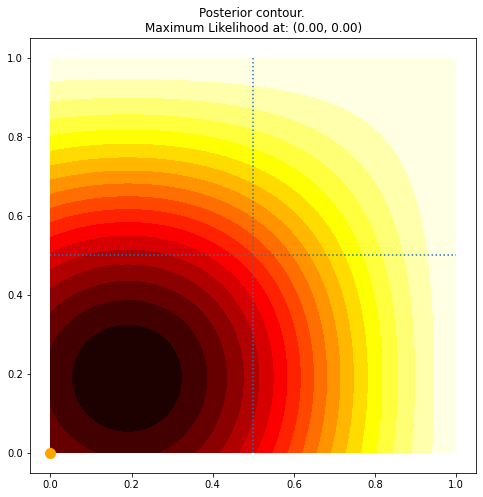

In [95]:
#hide_input
plot_likelihood(1, 0, 1, 0, use_prior=True)

# Decision tree


An illustration of a "regression tree": See [sklearn docs](https://scikit-learn.org/stable/modules/tree.html)
![](https://scikit-learn.org/stable/_images/sphx_glr_plot_tree_regression_001.png)